In [11]:
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Plotting starting play probabilities

In [12]:
# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Construct the full path to the CSV file
csv_file_path = parent_dir + '/results/nfsp_initial_action_probabilities.csv'

print(f"Reading CSV file from: {csv_file_path}")

Reading CSV file from: /Users/brunozorrilla/Documents/GitHub/marl_dominoes/marl_dominoes/results/nfsp_initial_action_probabilities.csv


In [13]:

# Assuming df is your DataFrame and 'action' is your column
df = pd.read_csv(csv_file_path, index_col=0) # , error_bad_lines=False)

# Create a new column 'frequency' to count the frequency of each action
df['frequency'] = df.groupby('action')['action'].transform('count')

# drop state column
df = df.drop(columns=['state'])

In [14]:

# Create a new column 'frequency' to count the frequency of each action
df['frequency'] = df.groupby('action')['action'].transform('count')

# Create a new column 'cumulative_probability' for cumulative probabilities
df['cumulative_probability'] = df.groupby('action')['prob'].transform('sum')

# Drop duplicate actions
df = df.drop_duplicates(subset='action')

# Calculate the total probability
total_probability = (df['cumulative_probability'] * df['frequency']).sum()

# Calculate the weighted probability
df['weighted_probability'] = df['cumulative_probability'] * df['frequency']/ total_probability

# verify that the sum of the weighted probabilities is 1
print(df['weighted_probability'].sum())

# Sort the DataFrame by 'weighted_probability' in descending order
df = df.sort_values(by='weighted_probability', ascending=False)



1.0000000000000002


In [15]:
df.head()

,action,prob,frequency,cumulative_probability,weighted_probability
49,75,0.857947,541,445.480356,0.178573
7,70,0.703098,556,349.934706,0.144162
15,0,0.369243,600,233.203585,0.103675
8,62,0.235800,570,214.716980,0.090684
0,72,0.302705,555,168.652108,0.069354


## part 2. recovering the actions 

In [16]:
_NUM_PLAYERS = 2
_PIPS = [0, 1, 2, 3, 4, 5, 6]
_DECK = list(itertools.combinations_with_replacement(_PIPS, 2))
_EDGES = [None, 0.0, 1, 2, 3, 4, 5, 6]

In [17]:
class Action:
  """Represent player possible action."""

  def __init__(self, player, tile, edge):
    self.player = player
    self.tile = tile
    self.edge = edge

  def __str__(self):
    return f"p{self.player} tile:{self.tile} pip:{self.edge}"

  def __repr__(self):
    return self.__str__()


def create_possible_actions():
  actions = []
  for player in range(_NUM_PLAYERS):
    for tile in _DECK:
      for edge in _EDGES:
        if edge in tile or edge is None:  # can we play tile on edge?
          actions.append(Action(player, tile, edge))
  return actions


In [18]:
ACTIONS = create_possible_actions()

# Part 3. Plotting according to tile

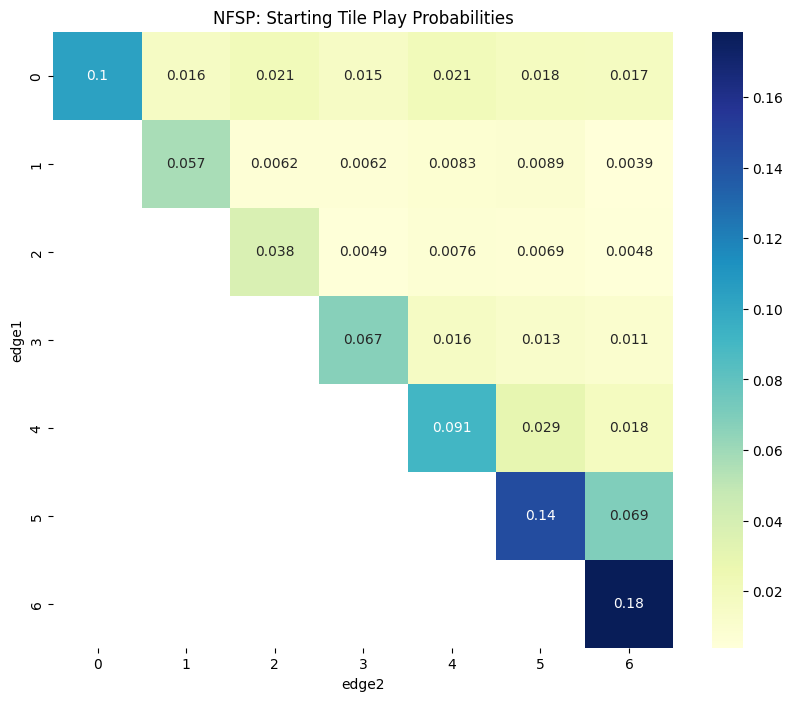

In [19]:
# Map the 'action' column to the actual tile edges
df['tile'] = df['action'].apply(lambda x: ACTIONS[x].tile)

# Split the 'tile' column into two separate columns
df[['edge1', 'edge2']] = pd.DataFrame(df['tile'].tolist(), index=df.index)

# Create a pivot table
pivot_table = df.pivot_table(values='weighted_probability', index='edge1', columns='edge2')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', )
plt.title('NFSP: Starting Tile Play Probabilities')
plt.show()

# by ranking

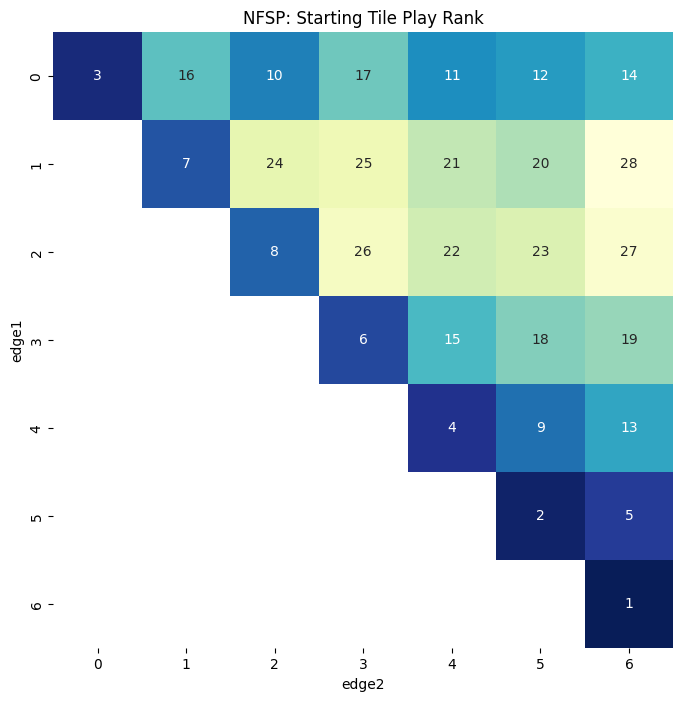

In [20]:
# Flatten the pivot table and calculate the rank of each probability
flat_values = pivot_table.values.flatten()
ranks = flat_values.argsort().argsort().astype(float)  # Convert ranks to float


# Rank from highest to lowest
ranks = ranks.max() + 1 - ranks - 21

# Assign no ranking to NaN values
ranks[np.isnan(flat_values)] = np.nan

# Reshape the ranks to the original shape of the pivot table
ranks = ranks.reshape(pivot_table.shape)

# Create a new DataFrame with the ranks
rank_df = pd.DataFrame(ranks, index=pivot_table.index, columns=pivot_table.columns)

# Create the heatmap with the ranks
plt.figure(figsize=(8, 8))
sns.heatmap(rank_df, annot=True, fmt=".0f", cmap='YlGnBu_r', cbar=False)
plt.title('NFSP: Starting Tile Play Rank')
plt.show()